Cloning into 'Amthal'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 101 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 2.84 MiB | 5.85 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/Amthal
Data loaded successfully. Found 4078 instances.

✅ الشبكات الثلاث تم بناؤها بنجاح.
✅ مقاييس المركزية تم حسابها لكل شبكة.

--- 🔬 نتائج اختبار الحساسية (Spearman's Rank Correlation) ---
            Comparison Degree_Correlation Degree_p_value Betweenness_Correlation Betweenness_p_value
Heuristic vs Raw Count              0.988          0.000                   0.451               0.040
   Heuristic vs Binary              0.952          0.000                  -0.045               0.847


--- 📊 جدول مقارنة ترتيب المفاهيم (Concept Centrality Ranks) ---
                              Heuristic_Degree_Rank  RawCount_Degree_Rank  \
Path             

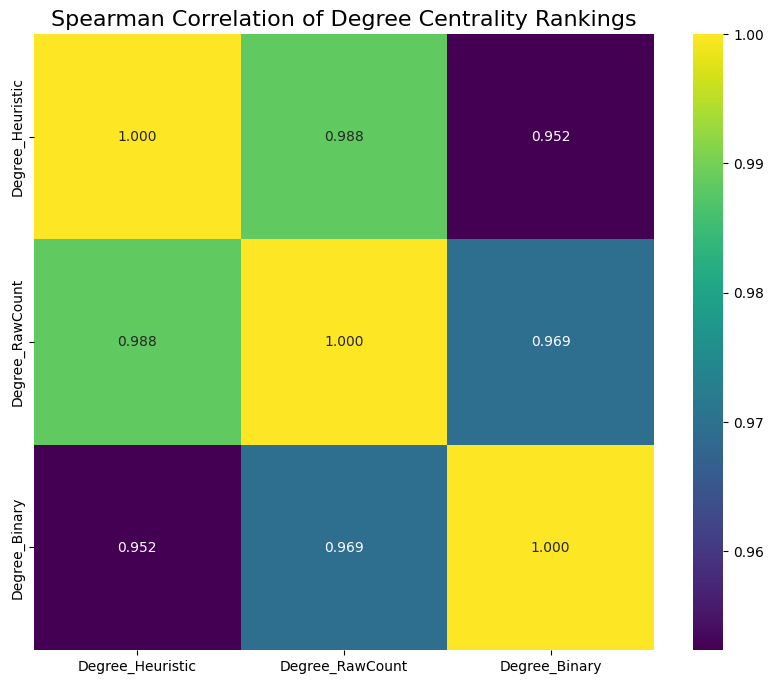

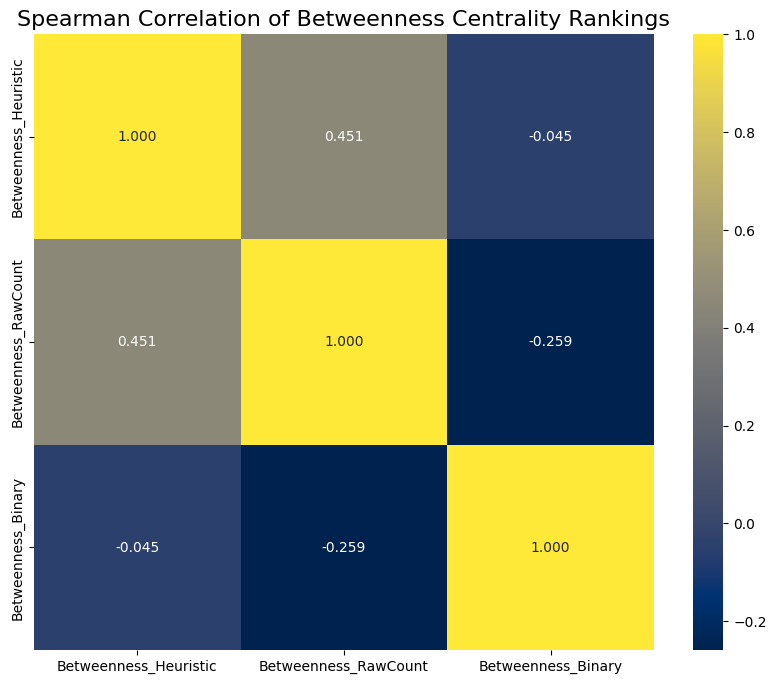

In [1]:

#@title **Sensitivity Analysis of Network Weighting Schemes**

!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output


import pandas as pd
import networkx as nx
from itertools import combinations
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# --- 1. إعداد البيانات ---


# --- [الخطوة 2: تحميل وتجهيز البيانات] ---
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()

# حساب طول كل آية (عدد الكلمات)
# .str.split() يقسم النص إلى قائمة كلمات، و .str.len() يحسب طول القائمة
df['verse_length'] = df['vers_text'].str.split().str.len()

# تجميع المفاهيم حسب الآية
# كل صف في grouped_concepts يمثل آية، ويحتوي على قائمة فريدة من المفاهيم وطول الآية
grouped_concepts = df.groupby(['Sura_No', 'Aya_No']).agg({
    'Dominant_Concept': lambda x: sorted(list(set(x))),
    'verse_length': 'first'
}).reset_index()

# --- 2. بناء الشبكات ---
def build_network(weighting_method):
    """
    Function to build a network based on a specified weighting method.
    Methods: 'heuristic', 'raw_count', 'binary'
    """
    G = nx.Graph()

    # إضافة جميع المفاهيم الفريدة كعقد في الشبكة
    all_concepts = df['Dominant_Concept'].unique()
    G.add_nodes_from(all_concepts)

    # المرور على كل آية لبناء الروابط
    for index, row in grouped_concepts.iterrows():
        concepts_in_verse = row['Dominant_Concept']
        verse_len = row['verse_length']

        # إنشاء روابط بين كل زوج من المفاهيم في نفس الآية
        if len(concepts_in_verse) > 1:
            for concept1, concept2 in combinations(concepts_in_verse, 2):
                # التأكد من أن الرابط موجود قبل تعديل الوزن
                if G.has_edge(concept1, concept2):
                    current_weight = G[concept1][concept2].get('weight', 0)
                else:
                    current_weight = 0

                # حساب الوزن الجديد بناءً على الطريقة المحددة
                if weighting_method == 'heuristic':
                    new_weight = current_weight + (1 / verse_len)
                elif weighting_method == 'raw_count':
                    new_weight = current_weight + 1
                elif weighting_method == 'binary':
                    new_weight = 1 # دائماً 1، لا يتراكم

                G.add_edge(concept1, concept2, weight=new_weight)

    return G

# بناء الشبكات الثلاث
G_heuristic = build_network('heuristic')
G_raw_count = build_network('raw_count')
G_binary = build_network('binary')

print("✅ الشبكات الثلاث تم بناؤها بنجاح.")

# --- 3. حساب مقاييس المركزية ---
def get_centralities(G, weight_arg='weight'):
    """
    Calculates degree and betweenness centralities for a given graph.
    """
    # Degree Centrality (or Strength for weighted graphs)
    degree = dict(G.degree(weight=weight_arg))

    # Betweenness Centrality
    betweenness = nx.betweenness_centrality(G, weight=weight_arg, normalized=True)

    # دمج النتائج في DataFrame
    centrality_df = pd.DataFrame({
        'Degree': degree,
        'Betweenness': betweenness
    }).sort_index()

    return centrality_df

# حساب المركزية لكل شبكة
centralities_heuristic = get_centralities(G_heuristic)
centralities_raw_count = get_centralities(G_raw_count)
# بالنسبة للشبكة الثنائية، لا نستخدم وسيط الوزن
centralities_binary = get_centralities(G_binary, weight_arg=None)

print("✅ مقاييس المركزية تم حسابها لكل شبكة.")

# --- 4. مقارنة النتائج (اختبار الحساسية) ---
def compare_rankings(df1, df2, method1_name, method2_name):
    """
    Compares centrality rankings between two dataframes using Spearman correlation.
    """
    # التأكد من أن المفاهيم بنفس الترتيب
    df1_sorted = df1.sort_index()
    df2_sorted = df2.sort_index()

    # مقارنة مركزية الدرجة
    corr_degree, p_degree = spearmanr(df1_sorted['Degree'], df2_sorted['Degree'])

    # مقارنة مركزية البينية
    corr_betweenness, p_betweenness = spearmanr(df1_sorted['Betweenness'], df2_sorted['Betweenness'])

    return {
        'Comparison': f"{method1_name} vs {method2_name}",
        'Degree_Correlation': f"{corr_degree:.3f}",
        'Degree_p_value': f"{p_degree:.3f}",
        'Betweenness_Correlation': f"{corr_betweenness:.3f}",
        'Betweenness_p_value': f"{p_betweenness:.3f}",
    }

# إجراء المقارنات
comparison1 = compare_rankings(centralities_heuristic, centralities_raw_count, 'Heuristic', 'Raw Count')
comparison2 = compare_rankings(centralities_heuristic, centralities_binary, 'Heuristic', 'Binary')

# تجميع نتائج المقارنة في DataFrame لعرضها
sensitivity_results = pd.DataFrame([comparison1, comparison2])

print("\n--- 🔬 نتائج اختبار الحساسية (Spearman's Rank Correlation) ---")
print(sensitivity_results.to_string(index=False))

# --- 5. عرض النتائج التفصيلية وترتيب المفاهيم ---
# إنشاء DataFrame موحد لعرض الترتيب
centrality_ranks = pd.DataFrame(index=centralities_heuristic.index)
centrality_ranks['Heuristic_Degree_Rank'] = centralities_heuristic['Degree'].rank(ascending=False).astype(int)
centrality_ranks['RawCount_Degree_Rank'] = centralities_raw_count['Degree'].rank(ascending=False).astype(int)
centrality_ranks['Binary_Degree_Rank'] = centralities_binary['Degree'].rank(ascending=False).astype(int)

centrality_ranks['Heuristic_Betweenness_Rank'] = centralities_heuristic['Betweenness'].rank(ascending=False).astype(int)
centrality_ranks['RawCount_Betweenness_Rank'] = centralities_raw_count['Betweenness'].rank(ascending=False).astype(int)
centrality_ranks['Binary_Betweenness_Rank'] = centralities_binary['Betweenness'].rank(ascending=False).astype(int)

# فرز النتائج حسب أهمية المفهوم في النموذج الأساسي
centrality_ranks = centrality_ranks.sort_values(by='Heuristic_Degree_Rank')

print("\n\n--- 📊 جدول مقارنة ترتيب المفاهيم (Concept Centrality Ranks) ---")
print(centrality_ranks)

# --- 6. تصور النتائج (اختياري ولكنه مفيد) ---
# دمج جميع قيم المركزية في DataFrame واحد لسهولة التصور
plot_df = pd.concat([
    centralities_heuristic.add_suffix('_Heuristic'),
    centralities_raw_count.add_suffix('_RawCount'),
    centralities_binary.add_suffix('_Binary')
], axis=1)

# تصور ارتباط مركزية الدرجة
plt.figure(figsize=(10, 8))
sns.heatmap(plot_df[['Degree_Heuristic', 'Degree_RawCount', 'Degree_Binary']].corr(method='spearman'),
            annot=True, cmap='viridis', fmt=".3f")
plt.title("Spearman Correlation of Degree Centrality Rankings", fontsize=16)
plt.show()

# تصور ارتباط مركزية البينية
plt.figure(figsize=(10, 8))
sns.heatmap(plot_df[['Betweenness_Heuristic', 'Betweenness_RawCount', 'Betweenness_Binary']].corr(method='spearman'),
            annot=True, cmap='cividis', fmt=".3f")
plt.title("Spearman Correlation of Betweenness Centrality Rankings", fontsize=16)
plt.show()